In [ ]:
from fastai.vision.all import *

In [ ]:
# !cp /content/drive/MyDrive/model_seg_1.pkl /content/
# !cp /content/drive/MyDrive/data/wardrobe_helper_data/models/attr_3_weighted_unfreeze.pkl /content/

In [ ]:
class Jaccard_multi_metricv2(Metric) :
      def __init__(self, dim_argmax = -1, **kwargs):
        super().__init__()
        # self.nc = nc
        self.dim_argmax = dim_argmax
        # self.value = 0
        self.kwargs = kwargs
        self.vals = []

      # def reset(self) :
      #   self.value = 0
      @staticmethod
      def Jaccard_multi(targ, pred, nc = 3) :
        targ = targ.clone()
        pred = pred.clone()
        pred[pred>0] = 1
        targ[targ>0] = 1
        # print(pred.shape, targ.shape)
        # sp = pred
        # ts = targ
        one_pred = F.one_hot(pred, nc)
        one_targ = F.one_hot(targ, nc)
        # return 1
        inter = ((one_pred == one_targ) * one_pred).sum(axis = tuple(range(len(pred.shape))))
        eps = 1e-9
        union = one_pred.sum(axis = tuple(range(len(pred.shape)))) + one_targ.sum(axis = tuple(range(len(pred.shape)))) - inter
        # assert union >= inter
        # print(union)
        # print((inter/union).mean().item()) 
        return (inter/union).nanmean().item()

      def accumulate(self, learner) :
        self.pred = learner.pred
        if self.dim_argmax: self.pred = self.pred.argmax(dim=self.dim_argmax)
        self.targ = learner.y
        assert self.pred.shape == self.targ.shape
        # print('g')
        val = self.Jaccard_multi(self.targ, self.pred, 10)#self.kwargs.get('nc', 10))
        self.vals.append(val)
        # print(val)
        # x = 1/0

      @property
      def value(self):
          "Value of the metric using accumulated preds and targs"
          # if len(self.pred) == 0: return
          # preds, targs = self.pred, self.targ
          # if self.to_np: preds,targs = preds.numpy(),targs.numpy()
          return np.mean(self.vals)

      def __call__(self, preds, targs):
          "Calculate metric on one batch of data"
          self.reset()
          self.pred = learner.pred
          if self.dim_argmax: self.pred = self.pred.argmax(dim=self.dim_argmax)
          self.targ = learner.y
          assert self.pred.shape == self.targ.shape
          return self.value()

In [ ]:
def _my_getter(path) : 
  return get_image_files(path/'train'/'image') + get_image_files(path/'valid'/'image')
def _my_y_getter(o) : 
  return Path((os.path.sep).join(str(o).split(os.sep)[:-2]))/'masks'/f'{o.stem}_m.png'

wp = 286.1918628411444
loss_fn = BCEWithLogitsLossFlat(reduction = 'none')
def my_loss(ypred, ytrue) :
        #print(ypred, ytrue)
        loss = loss_fn(ypred, ytrue)
        loss[ytrue.ravel() == 1] *= wp
        return loss.mean() * (1 + 1 / wp) / 2 

seg_learner = load_learner('model_seg_1.pkl')#, cpu = False) 
attribute_learner = load_learner('attr_3_weighted_unfreeze.pkl')#, cpu = False) 

In [ ]:
# for base, fol, imgs in os.walk('/content/drive/MyDrive/data/wardrobe_helper_data/recommender/data') : 
imgs = get_image_files('/content/drive/MyDrive/data/wardrobe_helper_data/recommender/data')

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
back = image2tensor(to_image(plt.imread('back.jpg')).resize((224, 224)))
X = []
for img in imgs :
  img, msk, *_ = seg_learner.predict(img, with_input = True)
  img1 = img * (msk == 1) + TensorImage(back) * (msk != 1) 
  img2 = img * (msk == 2) + TensorImage(back) * (msk != 2) 
  # img1.show()
  # img2.show()
  atr1 = torch.sigmoid(attribute_learner.predict(img1)[1])
  atr2 = torch.sigmoid(attribute_learner.predict(img2)[1])
  X.append([np.array(atr1), np.array(atr2)]) 

In [ ]:
Kx = np.array(X).reshape((-1, 1000))

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
n = 10

In [ ]:
kmeans_model = KMeans(n).fit(Kx)

In [ ]:
# kmeans_model.predict(X[0][0].reshape(1, -1))

In [ ]:
memory_matrix = np.zeros((n, n))

for pair in X :
  cloth1 = kmeans_model.predict(pair[0].reshape(1, -1))
  cloth2 = kmeans_model.predict(pair[1].reshape(1, -1))
  memory_matrix[cloth1, cloth2] += 1
  memory_matrix[cloth2, cloth1] += 1

In [ ]:
# memory_matrix

array([[2., 2., 1., 3., 1., 0., 1., 1., 0., 0.],
       [2., 2., 2., 0., 1., 1., 1., 3., 1., 0.],
       [1., 2., 4., 0., 1., 0., 0., 3., 0., 2.],
       [3., 0., 0., 0., 0., 0., 0., 5., 0., 0.],
       [1., 1., 1., 0., 0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 1., 1., 0.],
       [1., 1., 0., 0., 0., 0., 0., 2., 2., 0.],
       [1., 3., 3., 5., 1., 1., 2., 0., 0., 0.],
       [0., 1., 0., 0., 0., 1., 2., 0., 6., 0.],
       [0., 0., 2., 0., 0., 0., 0., 0., 0., 0.]])

In [ ]:
y_rank_matrix = np.argsort(np.argsort(memory_matrix, axis = 0), axis = 0)
x_rank_matrix = np.argsort(np.argsort(memory_matrix, axis = 1), axis = 1)

In [ ]:
def recommender(shirt, pant) :
  img, msk, *_ = seg_learner.predict(shirt, with_input = True)
  img.show()
  img1 = img * (msk == 1) + TensorImage(back) * (msk != 1) 
  atr1 = torch.sigmoid(attribute_learner.predict(img1)[1])

  img, msk, *_ = seg_learner.predict(pant, with_input = True)
  img.show()

  img2 = img * (msk == 1) + TensorImage(back) * (msk != 1) 
  atr2 = torch.sigmoid(attribute_learner.predict(img2)[1])

  cloth1 = kmeans_model.predict(atr1.reshape(1, -1).numpy())
  cloth2 = kmeans_model.predict(atr2.reshape(1, -1).numpy())
  print(cloth1, cloth2)
  x_rank = x_rank_matrix[cloth1, cloth2]
  y_rank = y_rank_matrix[cloth1, cloth2]

  print('final match score :', x_rank * y_rank / (n-1)**2)

In [ ]:
pants = get_image_files('/content/drive/MyDrive/data/wardrobe_helper_data/recommender/test_data/pant')
shirts = get_image_files('/content/drive/MyDrive/data/wardrobe_helper_data/recommender/test_data/shirt')

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[4] [7]
final match score : [0.44444444]


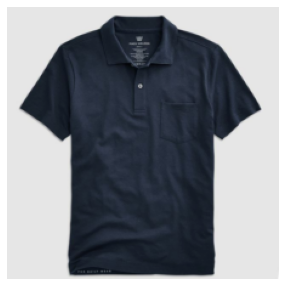

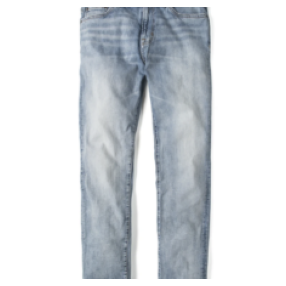

In [ ]:
recommender(shirts[1], pants[1])

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[4] [7]
final match score : [0.44444444]


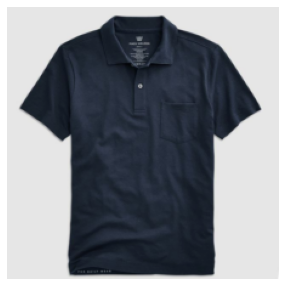

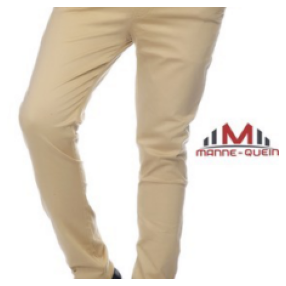

In [ ]:
recommender(shirts[1], pants[2])